# **Section 0: Imports and Install📢**

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# **Section 1: Load Dataset📑**

## 1-1: Read Dataset

In [2]:
data = pd.read_csv('./data/train.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
1,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
2,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
3,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
4,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1


In [3]:
data['DEATH_EVENT'].value_counts()

0    171
1     78
Name: DEATH_EVENT, dtype: int64

In [4]:
len(data)

249

In [5]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

## 1-2: Train_Test_Split

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((199, 12), (50, 12), (199,), (50,))

## 1-3: Preprocessing

In [7]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.LongTensor(y_train.values)

x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.LongTensor(y_valid.values)

In [8]:
# Standardization
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)
mu, std

(tensor([5.9621e+01, 3.8191e-01, 5.7404e+02, 3.8191e-01, 3.7774e+01, 3.6181e-01,
         2.5571e+05, 1.3656e+00, 1.3652e+02, 6.5327e-01, 3.2663e-01, 1.3182e+02]),
 tensor([1.1176e+01, 4.8708e-01, 9.5891e+02, 4.8708e-01, 1.1973e+01, 4.8174e-01,
         8.9907e+04, 1.0280e+00, 4.2851e+00, 4.7713e-01, 4.7016e-01, 7.6886e+01]))

In [9]:
x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

## 1-4: Dataloader

In [10]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# **Section 2: Define Model🧠**

## 2-1: make your MLP Model

In [11]:
num_features = x_train.shape[1]
num_classes = 1

model = nn.Sequential(
    nn.Linear(num_features, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, num_classes),
)

In [12]:
model

Sequential(
  (0): Linear(in_features=12, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

## 2-2: Loss and Optimizer

In [13]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## 2-3: Bias for last layer(before train)

In [14]:
model[-1].bias

Parameter containing:
tensor([0.0301], requires_grad=True)

# **Section 3: Device⚙️**

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
model.to(device)

Sequential(
  (0): Linear(in_features=12, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

# **Section 4: Train Model🤓**

## 4-1:Utils

In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## 4-1: Torchmetrics

In [18]:
from torchmetrics import Accuracy

## 4-2:Train Loop

In [19]:
import time

In [20]:
num_epochs = 300

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

start = time.time()

for epoch in range(num_epochs):
  loss_train = AverageMeter()
  acc_train = Accuracy(task='binary').to(device)
  for i, (inputs, targets) in enumerate(train_loader):
    inputs = inputs.to(device)
    targets = targets.unsqueeze(1).float().to(device)

    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_train.update(loss.item())
    acc_train(outputs, targets)

  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='binary').to(device)
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.unsqueeze(1).float().to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets)

  loss_train_hist.append(loss_train.avg)
  loss_valid_hist.append(loss_valid.avg)

  acc_train_hist.append(acc_train.cpu().compute())
  acc_valid_hist.append(acc_valid.cpu().compute())

  if epoch % 50 == 0:
      print(f'Epoch: {epoch}, Train Loss: {loss_train.avg:.4f}, Train Acc: {acc_train.compute():.4f}, Valid Loss: {loss_valid.avg:.4f}, Valid Acc: {acc_valid.compute():.4f}')

end = time.time()
print(f"Training Time = {end - start:.4} s")

Epoch: 0, Train Loss: 0.7139, Train Acc: 0.6432, Valid Loss: 0.6878, Valid Acc: 0.5800
Epoch: 50, Train Loss: 0.2517, Train Acc: 0.9095, Valid Loss: 0.2708, Valid Acc: 0.9000
Epoch: 100, Train Loss: 0.0917, Train Acc: 0.9849, Valid Loss: 0.4151, Valid Acc: 0.8800
Epoch: 150, Train Loss: 0.0298, Train Acc: 1.0000, Valid Loss: 0.6536, Valid Acc: 0.8600
Epoch: 200, Train Loss: 0.0135, Train Acc: 1.0000, Valid Loss: 0.8280, Valid Acc: 0.8200
Epoch: 250, Train Loss: 0.0077, Train Acc: 1.0000, Valid Loss: 0.9421, Valid Acc: 0.8200
Training Time = 71.86 s


# **Section 5: Result📈**

## 5-1:Plot loss and acc

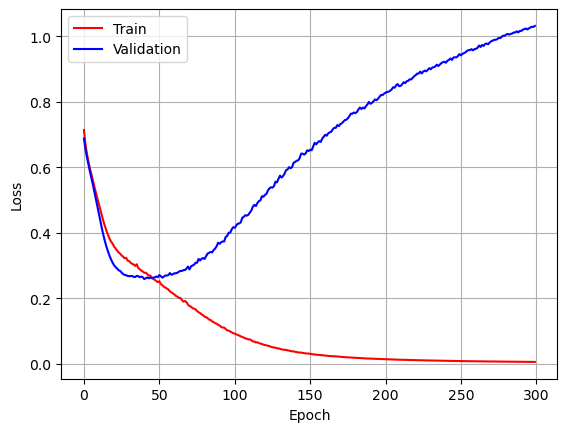

In [21]:
# plot loss_epoch
plt.plot(range(num_epochs), loss_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

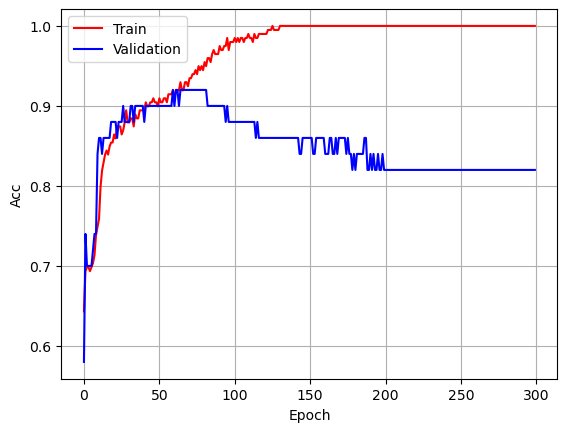

In [22]:
# plot acc_epoch
plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

## 5-2:Count param

In [23]:
torch.tensor([torch.numel(p) for p in model.parameters()]).sum()

tensor(2945)

## 5-3: Bias for last layer(after train)

In [24]:
model[-1].bias

Parameter containing:
tensor([-0.5825], device='cuda:0', requires_grad=True)

# **Section 6: Save and Load Model💰**

## 6-1: Save

In [25]:
torch.save(model, './out/ProduceModel.pth')

## 6-2: Load

In [26]:
model_1 = torch.load('./out/ProduceModel.pth')
model_1

Sequential(
  (0): Linear(in_features=12, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

# **Section 7: Model Prediction🩺**

## 7-1: Use test.csv

In [29]:
df_test = pd.read_csv('./data/test.csv')
df_test.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4
1,90.0,1,47,0,40,1,204000.0,2.1,132,1,1,8
2,62.0,0,231,0,25,1,253000.0,0.9,140,1,1,10
3,87.0,1,149,0,38,0,262000.0,0.9,140,1,0,14
4,80.0,0,148,1,38,0,149000.0,1.9,144,1,1,23


In [30]:
x_test = torch.FloatTensor(df_test.values)
x_test

tensor([[7.5000e+01, 0.0000e+00, 5.8200e+02, 0.0000e+00, 2.0000e+01, 1.0000e+00,
         2.6500e+05, 1.9000e+00, 1.3000e+02, 1.0000e+00, 0.0000e+00, 4.0000e+00],
        [9.0000e+01, 1.0000e+00, 4.7000e+01, 0.0000e+00, 4.0000e+01, 1.0000e+00,
         2.0400e+05, 2.1000e+00, 1.3200e+02, 1.0000e+00, 1.0000e+00, 8.0000e+00],
        [6.2000e+01, 0.0000e+00, 2.3100e+02, 0.0000e+00, 2.5000e+01, 1.0000e+00,
         2.5300e+05, 9.0000e-01, 1.4000e+02, 1.0000e+00, 1.0000e+00, 1.0000e+01],
        [8.7000e+01, 1.0000e+00, 1.4900e+02, 0.0000e+00, 3.8000e+01, 0.0000e+00,
         2.6200e+05, 9.0000e-01, 1.4000e+02, 1.0000e+00, 0.0000e+00, 1.4000e+01],
        [8.0000e+01, 0.0000e+00, 1.4800e+02, 1.0000e+00, 3.8000e+01, 0.0000e+00,
         1.4900e+05, 1.9000e+00, 1.4400e+02, 1.0000e+00, 1.0000e+00, 2.3000e+01],
        [8.2000e+01, 1.0000e+00, 8.5500e+02, 1.0000e+00, 5.0000e+01, 1.0000e+00,
         3.2100e+05, 1.0000e+00, 1.4500e+02, 0.0000e+00, 0.0000e+00, 3.0000e+01],
        [6.0000e+01, 0

In [31]:
x_test = (x_test - mu) / std
x_test

tensor([[ 1.3761, -0.7841,  0.0083, -0.7841, -1.4845,  1.3248,  0.1034,  0.5198,
         -1.5222,  0.7267, -0.6947, -1.6624],
        [ 2.7182,  1.2690, -0.5496, -0.7841,  0.1859,  1.3248, -0.5751,  0.7144,
         -1.0554,  0.7267,  1.4322, -1.6104],
        [ 0.2128, -0.7841, -0.3577, -0.7841, -1.0669,  1.3248, -0.0301, -0.4530,
          0.8115,  0.7267,  1.4322, -1.5844],
        [ 2.4498,  1.2690, -0.4432, -0.7841,  0.0189, -0.7511,  0.0700, -0.4530,
          0.8115,  0.7267, -0.6947, -1.5324],
        [ 1.8235, -0.7841, -0.4443,  1.2690,  0.0189, -0.7511, -1.1869,  0.5198,
          1.7450,  0.7267,  1.4322, -1.4153],
        [ 2.0024,  1.2690,  0.2930,  1.2690,  1.0212,  1.3248,  0.7262, -0.3557,
          1.9784, -1.3692, -0.6947, -1.3243],
        [ 0.0339, -0.7841,  0.0083,  1.2690,  0.0189,  1.3248,  2.1722, -0.7448,
          0.3448,  0.7267,  1.4322, -1.1942],
        [-1.3083, -0.7841,  7.4334,  1.2690, -1.0669,  1.3248,  1.4937, -0.3557,
          0.5781,  0.7267, -0.

In [32]:
model_1.append(nn.Sigmoid())
model_1

Sequential(
  (0): Linear(in_features=12, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)

In [34]:
yp = model_1(x_test.to(device))
yp

tensor([[1.0000e+00],
        [9.9999e-01],
        [9.9817e-01],
        [9.9408e-01],
        [9.9917e-01],
        [9.9904e-01],
        [9.9998e-01],
        [9.9992e-01],
        [9.5140e-01],
        [7.4235e-04],
        [9.9376e-01],
        [1.0000e+00],
        [9.9998e-01],
        [9.9886e-01],
        [9.9998e-01],
        [2.4612e-01],
        [1.7283e-04],
        [7.1786e-06],
        [9.5639e-01],
        [1.9270e-10],
        [4.8766e-07],
        [5.8685e-04],
        [3.7422e-05],
        [9.2854e-01],
        [3.9243e-04],
        [2.2631e-06],
        [2.5095e-04],
        [6.0584e-10],
        [3.7009e-06],
        [1.0420e-01],
        [1.0000e+00],
        [5.9099e-06],
        [1.4141e-04],
        [2.7261e-02],
        [9.9782e-01],
        [9.9978e-01],
        [2.0709e-03],
        [9.9996e-01],
        [9.9808e-01],
        [9.8750e-01],
        [9.9999e-01],
        [9.9967e-01],
        [9.9137e-01],
        [2.2723e-03],
        [9.9971e-01],
        [1

## 7-2 Make predictions.csv file

In [35]:
df = pd.DataFrame(yp.cpu().detach(), columns=['pred'])
df.to_csv('./out/prediction.csv')

# **Section 8: Hyperparam🔨**

## 8-1: Change hyperparam

Plot loss_epoch for batch_size:4,8,16

Plot loss_epoch for learningrate:0.1 , 0.01,0.001

Plot loss_epoch for layer:2,3,4

## 8-2: Calculate time

Train with CPU

time GPU VS CPU

## 8-3:Activation Function

Plot acc_epoch for LeakyReLU and GeLU